In [0]:
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import col, month, sum, year, when
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("Greens", as_cmap=False) 
sns.set_palette(custom_palette)

spark = SparkSession.builder.appName("Retail Data Analysis").getOrCreate()


In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Importação e tratamento dos dados

In [0]:
retail_df = spark.read.format('csv').option("header", "true").option('inferSchema', 'true').load('s3://retail-project-data-engineering/Retail_sales.csv')
retail_df.show()

+----------+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+
|  Store ID|Product ID|      Date|Units Sold|Sales Revenue (USD)|Discount Percentage|Marketing Spend (USD)|      Store Location|Product Category|Day of the Week|Holiday Effect|
+----------+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+
|Spearsland|  52372247|2022-01-01|         9|            2741.69|                 20|                   81|            Tanzania|       Furniture|       Saturday|         false|
|Spearsland|  52372247|2022-01-02|         7|            2665.53|                  0|                    0|          Mauritania|       Furniture|         Sunday|         false|
|Spearsland|  52372247|2022-01-03|         1|             380.79|                  0|                    0|Saint Pi

In [0]:
retail_df.printSchema()

root
 |-- Store ID: string (nullable = true)
 |-- Product ID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Units Sold: integer (nullable = true)
 |-- Sales Revenue (USD): double (nullable = true)
 |-- Discount Percentage: integer (nullable = true)
 |-- Marketing Spend (USD): integer (nullable = true)
 |-- Store Location: string (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Day of the Week: string (nullable = true)
 |-- Holiday Effect: boolean (nullable = true)



In [0]:
num_linhas = retail_df.count()
num_col = len(retail_df.columns)

print("Numero de linhas: ", num_linhas)
print("Numero de colunas: ", num_col)
print(retail_df.columns)

Numero de linhas:  30000
Numero de colunas:  11
['Store ID', 'Product ID', 'Date', 'Units Sold', 'Sales Revenue (USD)', 'Discount Percentage', 'Marketing Spend (USD)', 'Store Location', 'Product Category', 'Day of the Week', 'Holiday Effect']


In [0]:
for c in retail_df.columns:
    valores_distintos = retail_df.select(c).distinct().count()
    print(f"Valores distintos para a coluna {c}: {valores_distintos}")

Valores distintos para a coluna Store ID: 1
Valores distintos para a coluna Product ID: 42
Valores distintos para a coluna Date: 731
Valores distintos para a coluna Units Sold: 32
Valores distintos para a coluna Sales Revenue (USD): 2545
Valores distintos para a coluna Discount Percentage: 5
Valores distintos para a coluna Marketing Spend (USD): 200
Valores distintos para a coluna Store Location: 243
Valores distintos para a coluna Product Category: 4
Valores distintos para a coluna Day of the Week: 7
Valores distintos para a coluna Holiday Effect: 2


In [0]:
retail_df = retail_df.drop('Store ID')
retail_df.show(5)

+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+
|Product ID|      Date|Units Sold|Sales Revenue (USD)|Discount Percentage|Marketing Spend (USD)|      Store Location|Product Category|Day of the Week|Holiday Effect|
+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+
|  52372247|2022-01-01|         9|            2741.69|                 20|                   81|            Tanzania|       Furniture|       Saturday|         false|
|  52372247|2022-01-02|         7|            2665.53|                  0|                    0|          Mauritania|       Furniture|         Sunday|         false|
|  52372247|2022-01-03|         1|             380.79|                  0|                    0|Saint Pierre and ...|       Furniture|         Monday|         false|
|  5

* Primeira transformação realizada: Remoção da coluns "Store ID", pois contém um único valor

In [0]:
for c in retail_df.columns:
    valores_nan = retail_df.filter(col(c).isNull()).count()
    print(f"Numero de valores nulos para a coluna {c}: {valores_nan}")

Numero de valores nulos para a coluna Product ID: 0
Numero de valores nulos para a coluna Date: 0
Numero de valores nulos para a coluna Units Sold: 0
Numero de valores nulos para a coluna Sales Revenue (USD): 0
Numero de valores nulos para a coluna Discount Percentage: 0
Numero de valores nulos para a coluna Marketing Spend (USD): 0
Numero de valores nulos para a coluna Store Location: 0
Numero de valores nulos para a coluna Product Category: 0
Numero de valores nulos para a coluna Day of the Week: 0
Numero de valores nulos para a coluna Holiday Effect: 0


* Como não há valores Nan no Dataframe, não é necessário fazer nenhum tratamento de dados quanto a esses valores

In [0]:
year_df = retail_df.withColumn('Year', year(col('Date')))
year_df.select(col('Year')).distinct().show()

+----+
|Year|
+----+
|2023|
|2022|
|2024|
+----+



In [0]:
retail_df = retail_df.withColumn("Month", month(col('Date')))
retail_df = retail_df.withColumn('Year', year(col('Date')))
retail_df.show(5)

+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+-----+----+
|Product ID|      Date|Units Sold|Sales Revenue (USD)|Discount Percentage|Marketing Spend (USD)|      Store Location|Product Category|Day of the Week|Holiday Effect|Month|Year|
+----------+----------+----------+-------------------+-------------------+---------------------+--------------------+----------------+---------------+--------------+-----+----+
|  52372247|2022-01-01|         9|            2741.69|                 20|                   81|            Tanzania|       Furniture|       Saturday|         false|    1|2022|
|  52372247|2022-01-02|         7|            2665.53|                  0|                    0|          Mauritania|       Furniture|         Sunday|         false|    1|2022|
|  52372247|2022-01-03|         1|             380.79|                  0|                    0|Saint Pierre and ..

* Foi adicionado a coluna 'Month'

In [0]:
renomear_colunas = {
    'Product Id' : 'product_id',
    'Date' : 'date',
    'Units Sold' : 'units_sold',
    'Sales Revenue (USD)' : 'sales_revenue',
    'Discount Percentage' : 'discount_percentage',
    'Marketing Spend (USD)' : 'marketing_spend',
    'Store Location' : 'store_location',
    'Product Category' : 'product_category',
    'Day of the Week' : 'day_of_week',
    'Holiday Effect' : 'holiday',
    'Month' : 'sales_month',
    'Year' : 'sales_year' 
}

for antigo, novo in renomear_colunas.items():
    retail_df = retail_df.withColumnRenamed(antigo, novo)

retail_df.show(5)

+----------+----------+----------+-------------+-------------------+---------------+--------------------+----------------+-----------+-------+-----------+----------+
|product_id|      date|units_sold|sales_revenue|discount_percentage|marketing_spend|      store_location|product_category|day_of_week|holiday|sales_month|sales_year|
+----------+----------+----------+-------------+-------------------+---------------+--------------------+----------------+-----------+-------+-----------+----------+
|  52372247|2022-01-01|         9|      2741.69|                 20|             81|            Tanzania|       Furniture|   Saturday|  false|          1|      2022|
|  52372247|2022-01-02|         7|      2665.53|                  0|              0|          Mauritania|       Furniture|     Sunday|  false|          1|      2022|
|  52372247|2022-01-03|         1|       380.79|                  0|              0|Saint Pierre and ...|       Furniture|     Monday|  false|          1|      2022|
|  5

* Para padronizar e facilitar na utilização das colunas, foram trocadas os nomes das colunas do Dataframe

## Análise de Dados

### Questões que irei responder:
#### 1) Qual foi o produto que mais vendeu em cada mês, considerando todas as lojas? 
#### 2) Quais produtos com maiores receitas, considerando todas as lojas? E os produtos com menores receitas?
#### 3) Quais localidades possuem maior e menor receita em cada ano?
#### 4) Qual receita média é maior, em dias de feriados ou em dias normais?

#### 1) Qual melhor mês de vendas para cada produto, considerando todas as lojas?

In [0]:
retail_df.createOrReplaceTempView("retail_df")

In [0]:
retail_df.columns

Out[13]: ['product_id',
 'date',
 'units_sold',
 'sales_revenue',
 'discount_percentage',
 'marketing_spend',
 'store_location',
 'product_category',
 'day_of_week',
 'holiday',
 'sales_month',
 'sales_year']

/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
Traceback 

Unexpected exception formatting exception. Falling back to standard exception


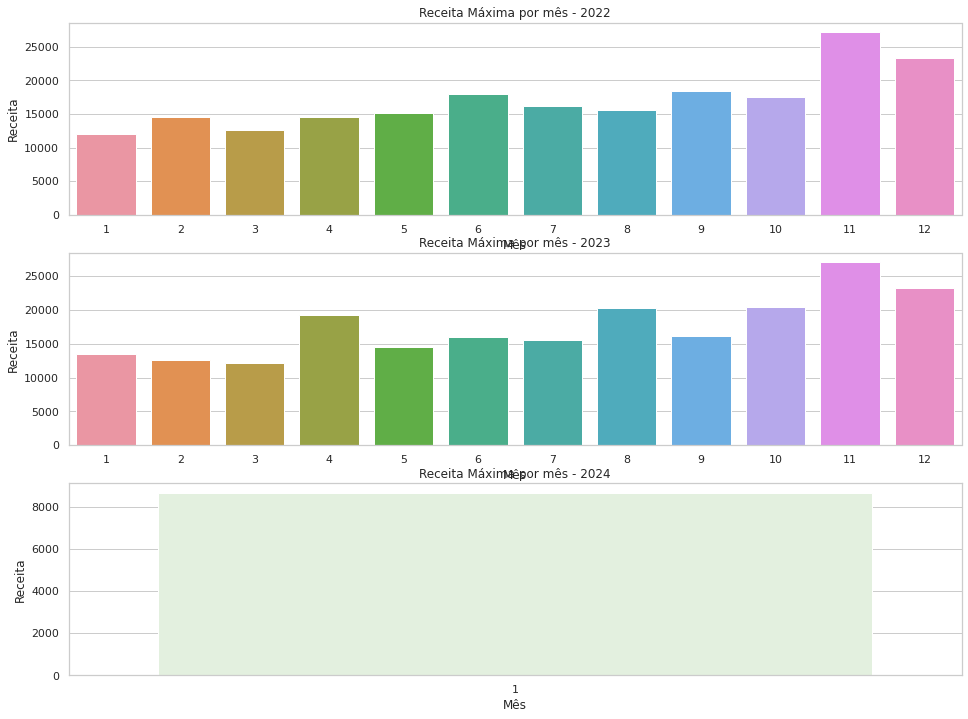

In [0]:
mes_produto_2022_df = spark.sql("""
SELECT DISTINCT product_id, sales_revenue, sales_month
FROM retail_df r
WHERE r.sales_year = 2022
  AND r.sales_revenue = (
      SELECT MAX(sales_revenue)
      FROM retail_df
      WHERE sales_year = 2022
      AND sales_month = r.sales_month
  )
""") 

mes_produto_2023_df = spark.sql("""
SELECT DISTINCT product_id, sales_revenue, sales_month
FROM retail_df r
WHERE r.sales_year = 2023
  AND r.sales_revenue = (
      SELECT MAX(sales_revenue)
      FROM retail_df
      WHERE sales_year = 2023
      AND sales_month = r.sales_month
  )
""") 

mes_produto_2024_df = spark.sql("""
SELECT DISTINCT product_id, sales_revenue, sales_month
FROM retail_df r
WHERE r.sales_year = 2024
  AND r.sales_revenue = (
      SELECT MAX(sales_revenue)
      FROM retail_df
      WHERE sales_year = 2024
      AND sales_month = r.sales_month
  )
""") 

mes_produto_2022_pd = mes_produto_2022_df.toPandas()
mes_produto_2023_pd = mes_produto_2023_df.toPandas()
mes_produto_2024_pd = mes_produto_2024_df.toPandas()


fig, ax = plt.subplots(3,1, figsize=(16,12))

barplot1 = sns.barplot('sales_month', 'sales_revenue', data=mes_produto_2022_pd, ax=ax[0])
ax[0].set_title('Receita Máxima por mês - 2022')
ax[0].set_xlabel("Mês")
ax[0].set_ylabel("Receita")

barplot2 = sns.barplot('sales_month', 'sales_revenue', data=mes_produto_2023_pd, ax=ax[1])
ax[1].set_title('Receita Máxima por mês - 2023')
ax[1].set_xlabel("Mês")
ax[1].set_ylabel("Receita")

barplot3 = sns.barplot('sales_month', 'sales_revenue', data=mes_produto_2024_pd, ax=ax[2])
ax[2].set_title('Receita Máxima por mês - 2024')
ax[2].set_xlabel("Mês")
ax[2].set_ylabel("Receita")

barplots = [barplot1, barplot2, barplot3]

for barplot in barplots:
    for index, row in barplot.iterrows():
        barplot.text(row.name, row['sales_revenue'] + 0.05, row['product_id'], color='black', ha="center")

"""for barplot in barplots:
    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.2f', label_type='edge') """

plt.tight_layout()
plt.plot()

#### 2) Quais produtos com maiores receitas, considerando todas as lojas? E os produtos com menores receitas?

In [0]:
retail_df.columns

Out[20]: ['product_id',
 'date',
 'units_sold',
 'sales_revenue',
 'discount_percentage',
 'marketing_spend',
 'store_location',
 'product_category',
 'day_of_week',
 'holiday',
 'sales_month',
 'sales_year']

In [0]:
produtos_maiores_receitas_2022_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2022
GROUP BY product_id, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

produtos_maiores_receitas_2023_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2023
GROUP BY product_id, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

produtos_maiores_receitas_2024_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2024
GROUP BY product_id, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

print(maiores_receitas_2022_df.select('sales_year').distinct().show())
print(maiores_receitas_2023_df.select('sales_year').distinct().show())
print(maiores_receitas_2024_df.select('sales_year').distinct().show())

+----------+
|sales_year|
+----------+
|      2022|
+----------+

None
+----------+
|sales_year|
+----------+
|      2023|
+----------+

None
+----------+
|sales_year|
+----------+
|      2024|
+----------+

None


/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


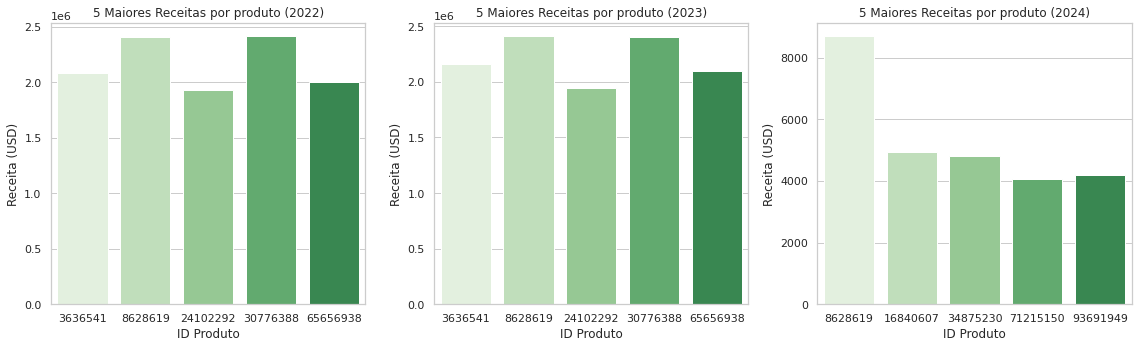

In [0]:
produtos_maiores_receitas_2022_pd = produtos_maiores_receitas_2022_df.toPandas()
produtos_maiores_receitas_2023_pd = produtos_maiores_receitas_2023_df.toPandas()
produtos_maiores_receitas_2024_pd = produtos_maiores_receitas_2024_df.toPandas()

y_2022 = produtos_maiores_receitas_2022_pd['sales_revenue']
x_2022 = produtos_maiores_receitas_2022_pd['product_id']

y_2023 = produtos_maiores_receitas_2023_pd['sales_revenue']
x_2023 = produtos_maiores_receitas_2023_pd['product_id']

y_2024 = produtos_maiores_receitas_2024_pd['sales_revenue']
x_2024 = produtos_maiores_receitas_2024_pd['product_id']

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(x_2022, y_2022, data=produtos_maiores_receitas_2022_pd ,ax=axs[0])
axs[0].set_title('5 Maiores Receitas por produto (2022)')
axs[0].set_ylabel('Receita (USD)')
axs[0].set_xlabel('ID Produto')

sns.barplot(x_2023, y_2023, data=produtos_maiores_receitas_2023_pd ,ax=axs[1])
axs[1].set_title('5 Maiores Receitas por produto (2023)')
axs[1].set_ylabel('Receita (USD)')
axs[1].set_xlabel('ID Produto')

sns.barplot(x_2024, y_2024, data=produtos_maiores_receitas_2024_pd ,ax=axs[2])
axs[2].set_title('5 Maiores Receitas por produto (2024)')
axs[2].set_ylabel('Receita (USD)')
axs[2].set_xlabel('ID Produto')

plt.tight_layout()
plt.show()

In [0]:
produtos_menores_receitas_2022_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2022
GROUP BY product_id, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

produtos_menores_receitas_2023_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2023
GROUP BY product_id, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

produtos_menores_receitas_2024_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, product_id, sales_year FROM retail_df df
WHERE sales_year = 2024
GROUP BY product_id, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

print(maiores_receitas_2022_df.select('sales_year').distinct().show())
print(maiores_receitas_2023_df.select('sales_year').distinct().show())
print(maiores_receitas_2024_df.select('sales_year').distinct().show())

+----------+
|sales_year|
+----------+
|      2022|
+----------+

None
+----------+
|sales_year|
+----------+
|      2023|
+----------+

None
+----------+
|sales_year|
+----------+
|      2024|
+----------+

None


/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


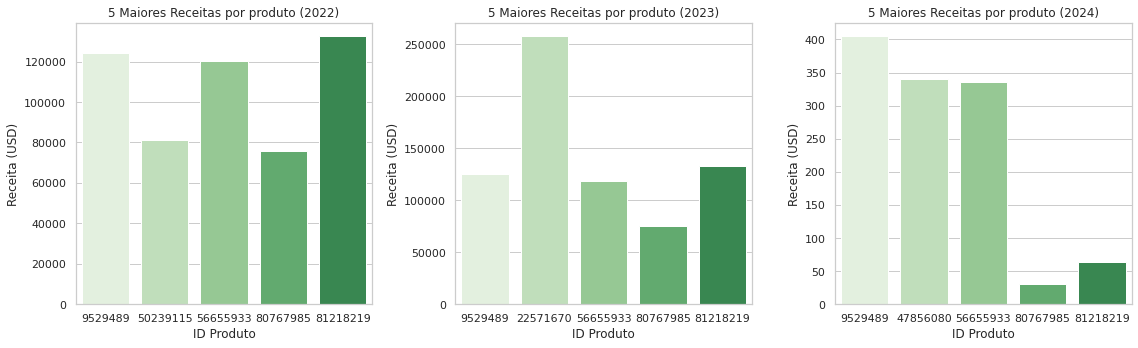

In [0]:
produtos_menores_receitas_2022_pd = produtos_menores_receitas_2022_df.toPandas()
produtos_menores_receitas_2023_pd = produtos_menores_receitas_2023_df.toPandas()
produtos_menores_receitas_2024_pd = produtos_menores_receitas_2024_df.toPandas()

y_2022 = produtos_menores_receitas_2022_pd['sales_revenue']
x_2022 = produtos_menores_receitas_2022_pd['product_id']

y_2023 = produtos_menores_receitas_2023_pd['sales_revenue']
x_2023 = produtos_menores_receitas_2023_pd['product_id']

y_2024 = produtos_menores_receitas_2024_pd['sales_revenue']
x_2024 = produtos_menores_receitas_2024_pd['product_id']

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(x_2022, y_2022, data=produtos_menores_receitas_2022_pd ,ax=axs[0])
axs[0].set_title('5 Menores Receitas por produto (2022)')
axs[0].set_ylabel('Receita (USD)')
axs[0].set_xlabel('ID Produto')

sns.barplot(x_2023, y_2023, data=produtos_menores_receitas_2023_pd ,ax=axs[1])
axs[1].set_title('5 Menores Receitas por produto (2023)')
axs[1].set_ylabel('Receita (USD)')
axs[1].set_xlabel('ID Produto')

sns.barplot(x_2024, y_2024, data=produtos_menores_receitas_2024_pd ,ax=axs[2])
axs[2].set_title('5 Menores Receitas por produto (2024)')
axs[2].set_ylabel('Receita (USD)')
axs[2].set_xlabel('ID Produto')

plt.tight_layout()
plt.show()

#### 3) Quais localidades possuem maior e menor receita em cada ano?

In [0]:
retail_df.show(5)

+----------+----------+----------+-------------+-------------------+---------------+--------------------+----------------+-----------+-------+-----------+----------+
|product_id|      date|units_sold|sales_revenue|discount_percentage|marketing_spend|      store_location|product_category|day_of_week|holiday|sales_month|sales_year|
+----------+----------+----------+-------------+-------------------+---------------+--------------------+----------------+-----------+-------+-----------+----------+
|  52372247|2022-01-01|         9|      2741.69|                 20|             81|            Tanzania|       Furniture|   Saturday|  false|          1|      2022|
|  52372247|2022-01-02|         7|      2665.53|                  0|              0|          Mauritania|       Furniture|     Sunday|  false|          1|      2022|
|  52372247|2022-01-03|         1|       380.79|                  0|              0|Saint Pierre and ...|       Furniture|     Monday|  false|          1|      2022|
|  5

* Foi dividido por ano, pois dessa forma é possível observar se houve evolução ou não de cada loja

In [0]:
maiores_receitas_2022_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2022
GROUP BY store_location, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

maiores_receitas_2023_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2023
GROUP BY store_location, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

maiores_receitas_2024_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2024
GROUP BY store_location, sales_year
ORDER BY sales_revenue DESC LIMIT 5
""")

print(maiores_receitas_2022_df.select('sales_year').distinct().show())
print(maiores_receitas_2023_df.select('sales_year').distinct().show())
print(maiores_receitas_2024_df.select('sales_year').distinct().show())

+----------+
|sales_year|
+----------+
|      2022|
+----------+

None
+----------+
|sales_year|
+----------+
|      2023|
+----------+

None
+----------+
|sales_year|
+----------+
|      2024|
+----------+

None


/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


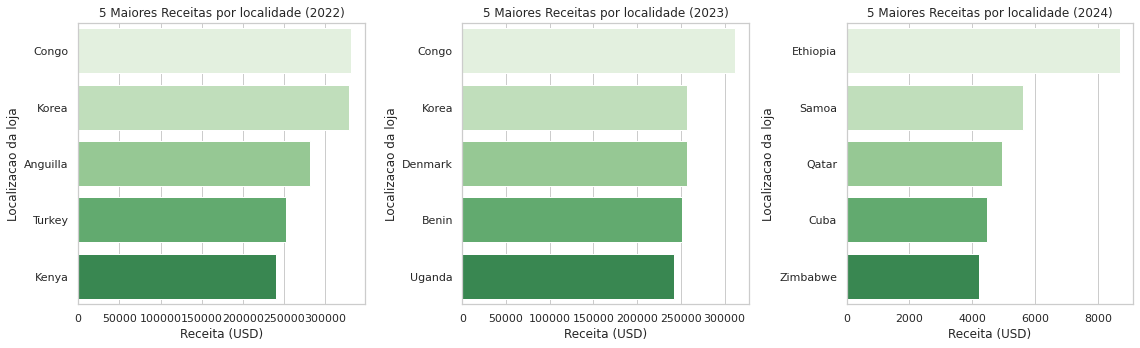

In [0]:
maiores_receitas_2022_pd = maiores_receitas_2022_df.toPandas()
maiores_receitas_2023_pd = maiores_receitas_2023_df.toPandas()
maiores_receitas_2024_pd = maiores_receitas_2024_df.toPandas()
                                                        
x_2022 = maiores_receitas_2022_pd['sales_revenue']
y_2022 = maiores_receitas_2022_pd['store_location']

x_2023 = maiores_receitas_2023_pd['sales_revenue']
y_2023 = maiores_receitas_2023_pd['store_location']

x_2024 = maiores_receitas_2024_pd['sales_revenue']
y_2024 = maiores_receitas_2024_pd['store_location']

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(x_2022, y_2022, data=maiores_receitas_2022_pd ,ax=axs[0])
axs[0].set_title('5 Maiores Receitas por localidade (2022)')
axs[0].set_xlabel('Receita (USD)')
axs[0].set_ylabel('Localizacao da loja')

sns.barplot(x_2023, y_2023, data=maiores_receitas_2023_pd ,ax=axs[1])
axs[1].set_title('5 Maiores Receitas por localidade (2023)')
axs[1].set_xlabel('Receita (USD)')
axs[1].set_ylabel('Localizacao da loja')

sns.barplot(x_2024, y_2024, data=maiores_receitas_2024_pd ,ax=axs[2])
axs[2].set_title('5 Maiores Receitas por localidade (2024)')
axs[2].set_xlabel('Receita (USD)')
axs[2].set_ylabel('Localizacao da loja')

plt.tight_layout()
plt.show()

* As localidades das lojas com maiores receitas em cada ano são:
  <p>2022: Congo</p>
  <p>2023: Congo</p>
  <p>2024: Ethiopia</p>

##### Verificando as lojas com menores receitas

In [0]:
menores_receitas_2022_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2022
GROUP BY store_location, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

menores_receitas_2023_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2023
GROUP BY store_location, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

menores_receitas_2024_df = spark.sql("""
SELECT SUM(sales_revenue) as sales_revenue, store_location, sales_year FROM retail_df df
WHERE sales_year = 2024
GROUP BY store_location, sales_year
ORDER BY sales_revenue ASC LIMIT 5
""")

print(menores_receitas_2022_df.select('sales_year').distinct().show())
print(menores_receitas_2023_df.select('sales_year').distinct().show())
print(menores_receitas_2024_df.select('sales_year').distinct().show())

+----------+
|sales_year|
+----------+
|      2022|
+----------+

None
+----------+
|sales_year|
+----------+
|      2023|
+----------+

None
+----------+
|sales_year|
+----------+
|      2024|
+----------+

None


/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


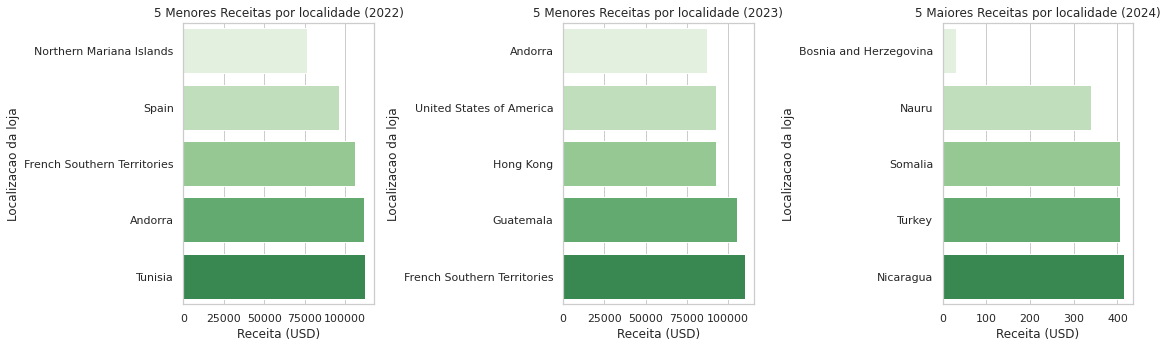

In [0]:
menores_receitas_2022_pd = menores_receitas_2022_df.toPandas()
menores_receitas_2023_pd = menores_receitas_2023_df.toPandas()
menores_receitas_2024_pd = menores_receitas_2024_df.toPandas()
                                                        
x_2022 = menores_receitas_2022_pd['sales_revenue']
y_2022 = menores_receitas_2022_pd['store_location']

x_2023 = menores_receitas_2023_pd['sales_revenue']
y_2023 = menores_receitas_2023_pd['store_location']

x_2024 = menores_receitas_2024_pd['sales_revenue']
y_2024 = menores_receitas_2024_pd['store_location']

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(x_2022, y_2022, data=menores_receitas_2022_pd ,ax=axs[0])
axs[0].set_title('5 Menores Receitas por localidade (2022)')
axs[0].set_xlabel('Receita (USD)')
axs[0].set_ylabel('Localizacao da loja')

sns.barplot(x_2023, y_2023, data=menores_receitas_2022_pd ,ax=axs[1])
axs[1].set_title('5 Menores Receitas por localidade (2023)')
axs[1].set_xlabel('Receita (USD)')
axs[1].set_ylabel('Localizacao da loja')

sns.barplot(x_2024, y_2024, data=menores_receitas_2022_pd ,ax=axs[2])
axs[2].set_title('5 Maiores Receitas por localidade (2024)')
axs[2].set_xlabel('Receita (USD)')
axs[2].set_ylabel('Localizacao da loja')

plt.tight_layout()
plt.show()

* As localidades das lojas com menores receitas em cada ano são:
  <p>2022: Nothern Mariana Islands</p>
  <p>2023: Andorra</p>
  <p>2024: Bosnia and Herzegovina</p>

#### 4) Qual receita média é maior? Em dias de feriados ou em dias normais?

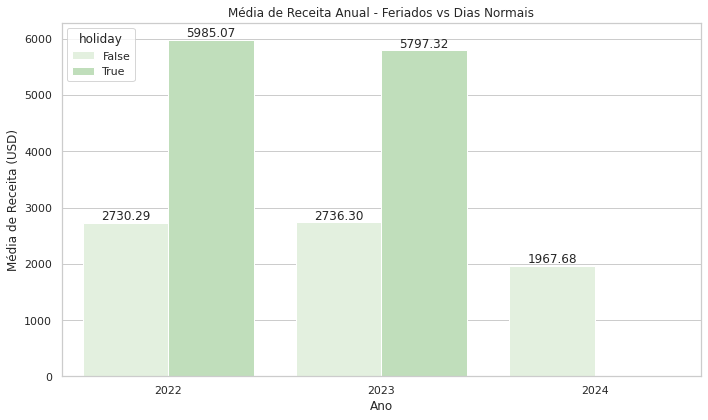

In [0]:
receita_media_feriado = spark.sql("""
SELECT AVG(sales_revenue) as mean_sales_revenue, sales_year, holiday FROM retail_df
WHERE holiday='True'
GROUP BY holiday, sales_year
""")

receita_media_dia_normal = spark.sql("""
SELECT AVG(sales_revenue) as mean_sales_revenue, sales_year, holiday FROM retail_df
WHERE holiday='False'
GROUP BY holiday, sales_year
""")

receita_media = receita_media_feriado.union(receita_media_dia_normal)
receita_media_pd = receita_media.toPandas()

plt.figure(figsize=(10, 6))  # Ajustar o tamanho do gráfico

barplot = sns.barplot(
    x='sales_year', 
    y='mean_sales_revenue', 
    hue='holiday', 
    data=receita_media_pd
)

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', label_type='edge') 

plt.title('Média de Receita Anual - Feriados vs Dias Normais')
plt.xlabel('Ano')
plt.ylabel('Média de Receita (USD)')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


* Em dias de feriado, a média de receita é maior do que em dias de receita em dias normais